In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from matplotlib.ticker import FuncFormatter

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "AA7077@nak",
                            database = "ecommerce")

cur = db.cursor()


#   1. List all unique cities where customers are located.

In [2]:
query = """ select distinct customer_city from customers"""

cur.execute(query)

data=cur.fetchall()

data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# 2. Count the number of orders placed in 2017.

In [3]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data=cur.fetchall()

print ("total no of order placed in 2017 are" ,data[0][0])

total no of order placed in 2017 are 135303


# 3. Find the total sales per category.

In [4]:
query = """ select products.product_category category, round(sum(payments.payment_value),2) sales 
from products join order_items on 
products.product_id = order_items.product_id 
join payments on 
payments.order_id=order_items.order_id 
group by category 
"""

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data, columns = ["category","sales"])
df

,category,sales
0,perfumery,2026954.64
1,Furniture Decoration,5720705.57
2,telephony,1947528.20
3,bed table bath,6850214.68
4,automotive,3409177.32
...,...,...
69,cds music dvds,4797.72
70,La Cuisine,11654.12
71,Fashion Children's Clothing,3142.68
72,PC Gamer,8697.72


# 4. Calculate the percentage of orders that were paid in installments.

In [5]:
query = """select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data=cur.fetchall()
print("The percentage of order that were paid in installment are", data[0][0], "% .")

The percentage of order that were paid in installment are 99.9981 % .


# 5. Count the number of customers from each state. 

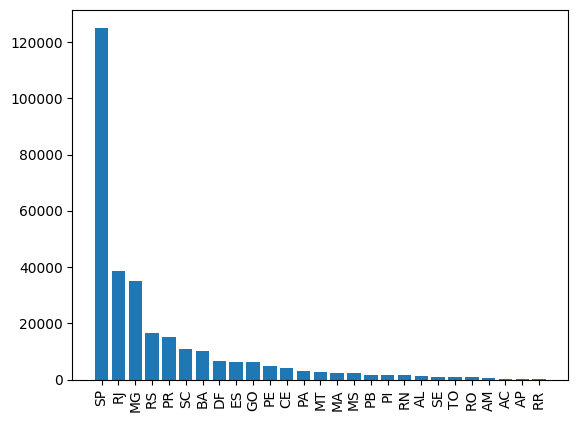

In [6]:
query = """ select customer_state, count(customer_id) from customers group by customer_state 
"""

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "no_of_customer"])
df = df.sort_values(by = "no_of_customer", ascending=False)
plt.bar(df["state"], df["no_of_customer"])
plt.xticks(rotation=90)
plt.show()

# 6. Calculate the number of orders per month in 2018.

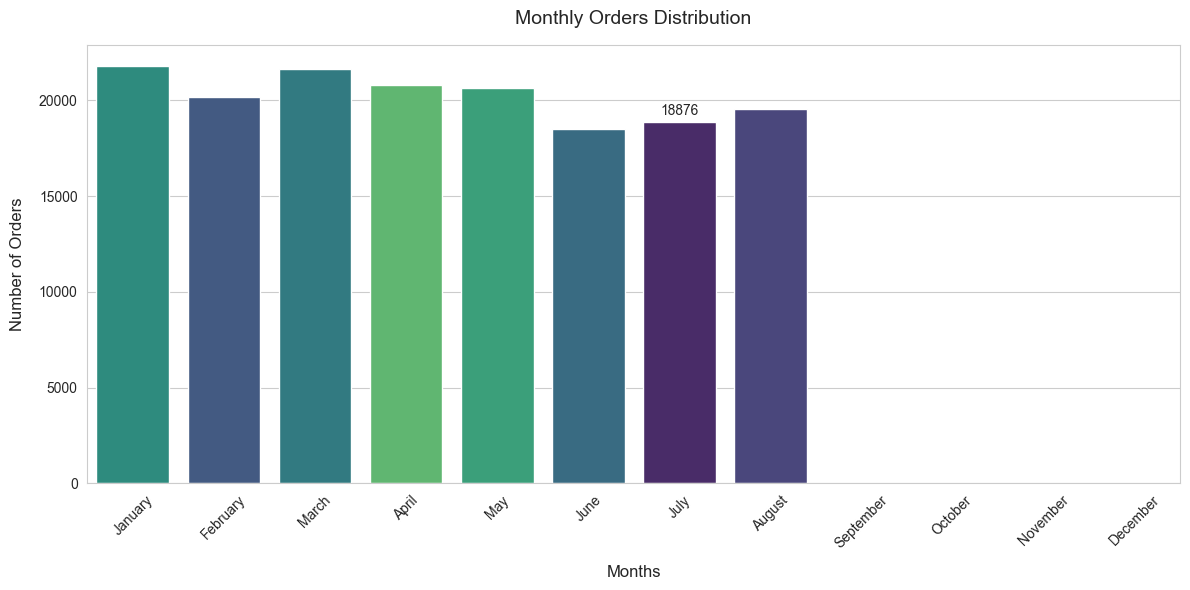

In [7]:
query = """ select monthname(order_purchase_timestamp) months , count(order_id) from orders where year(order_purchase_timestamp) = 2018
group by months """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Months", "Orders"])

month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]


sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x="Months", 
    y="Orders", 
    data=df, 
    hue="Months",  
    palette="viridis", 
    order=month_order,
    dodge=False  
)


ax.bar_label(ax.containers[0], fmt='%d', fontsize=10, padding=3)
plt.xticks(rotation=45, fontsize=10)
plt.xlabel("Months", fontsize=12, labelpad=10)
plt.ylabel("Number of Orders", fontsize=12, labelpad=10)
plt.title("Monthly Orders Distribution", fontsize=14, pad=15)
plt.legend([], [], frameon=False) 
plt.tight_layout()
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [8]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items on
orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id )
select customers.customer_city , round(avg(count_per_order.oc),2) as average_order
from customers join count_per_order on 
customers.customer_id=count_per_order.customer_id 
group by customers.customer_city ; """

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city","Avg_order"])
df.head(10)

,customer_city,Avg_order
0,treze tilias,3.82
1,indaial,3.35
2,sao jose dos campos,3.42
3,sao paulo,3.47
4,porto alegre,3.52
5,santos,3.48
6,sao francisco do sul,3.71
7,sao vicente,3.27
8,joinville,3.31
9,sao vendelino,3.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [9]:
query = """ select upper(products.product_category) category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100 , 2 ) sales_percentage
from products join order_items on
products.product_id=order_items.product_id
join payments on 
payments.order_id = order_items.order_id
group by category order by sales_percentage desc ; """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","% Revenue"])
df

,Category,% Revenue
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
...,...,...
69,PC GAMER,0.03
70,HOUSE COMFORT 2,0.02
71,CDS MUSIC DVDS,0.01
72,FASHION CHILDREN'S CLOTHING,0.01


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query = """ select products.product_category,count(order_items.product_id),round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category  """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]
coe = np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased.", coe[0][1])

the correlation between product price and the number of times a product has been purchased. -0.10631514167157562


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

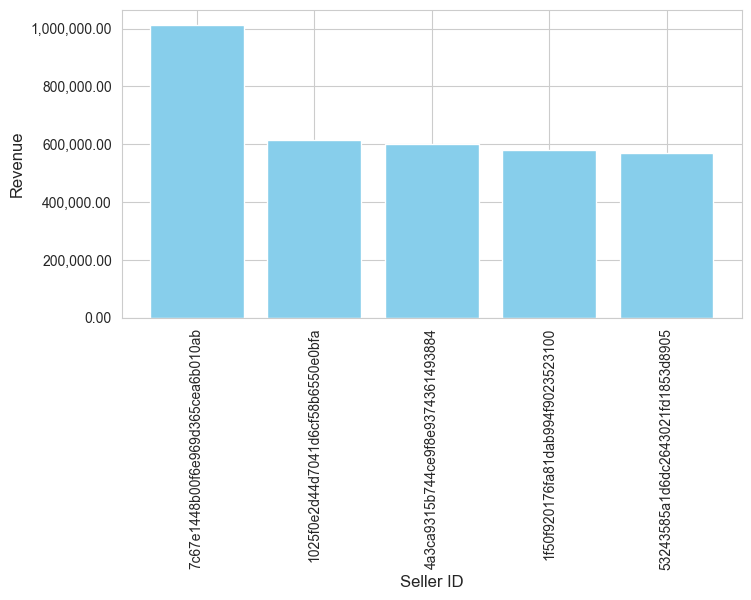

In [11]:
query = """  select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, round(sum(payments.payment_value),2)
revenue from order_items join payments 
on order_items.order_id=payments.order_id 
group by order_items.seller_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["seller_id","revenue","rank"])
df=df.head(5)
x = df["seller_id"]
y = df["revenue"]

def format_func(value, tick_number):
    return f"{value:,.2f}"
    
plt.figure(figsize=(8, 4))  
plt.bar(x, y, color="skyblue") 
plt.xlabel("Seller ID", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xticks(rotation=90)
plt.show()